In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.parameter import Parameter

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.receptive_field_analysis.visualization as rfvis
import allensdk.brain_observatory.receptive_field_analysis.receptive_field as rf
from allensdk.brain_observatory.receptive_field_analysis.eventdetection import detect_events
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

/home/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [3]:
# Specify output directories and cache results
def cached(results_dir, results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper

    return _cache

In [4]:
# ids = [501474098,
#  501847516]

ids = [
    501474098,
    501847516,
    505693621,
    501773889,
    511977695,
    530047022,
    503864409,
    502383036,
    540168837,
    527583578,
    528693630,
    539540432,
    510535700,
    510656082,
    511305590,
    502665019,
    530739576,
    505811062,
    501879034,
    502483554,
    506353473,
    508220632,
    537153918
]

num_experiments = len(ids)

#note: 23 total, since each of the 6 cre-lines only has 1-3 different depths and 1-4 different brain locations


In [5]:
def get_data(i):
    data = boc.get_ophys_experiment_data(i)
    stimulus_table = data.get_stimulus_table("locally_sparse_noise")
    x = data.get_stimulus_template("locally_sparse_noise")[stimulus_table['frame'].values, :, :]
    N_frames, H_px, W_px = x.shape
    x = x.reshape((N_frames, H_px * W_px))
    y = []
    print("detecting events in dataset {}...".format(i))
    for n in tqdm(range(data.number_of_cells)):
        events = detect_events(data, n, "locally_sparse_noise")
        if (events.sum() > 20):
            y.append(events)
    y = np.asarray(y).T
    return x, y

In [6]:
X, Y, num_neurons = [], [], []
for i in ids:
    f = cached("data", "{}.pkl".format(i))(get_data)
    xi, yi = f(i)
    X.append(xi)
    Y.append(yi)
    num_neurons.append(yi.shape[1])

In [7]:
# standardize the data
for i in range(len(X)):
    x = np.array(X[i], dtype=np.float64)
    x -= x.mean()
    x /= x.std()
    X[i] = x

In [8]:
# split into test and train
X_train = []
X_test = []
y_train = []
y_test = []
for i in range(len(X)):
    X_tr, X_te, y_tr, y_te = train_test_split(X[i], Y[i], test_size=0.33, random_state=42)
    X_train.append(X_tr)
    X_test.append(X_te)
    y_train.append(y_tr)
    y_test.append(y_te)

In [9]:
from sklearn import linear_model

def logistic_(X, Y, i):
    Cs = [10, 1.0, 0.1, 0.01]
    scores = []
    lrs = []

    for C in Cs:
        lr = linear_model.LogisticRegression(C=C, penalty='l1', warm_start=True)
        C_mean = np.mean(cross_val_score(lr, X, Y[:,i], cv=5))
        scores.append(C_mean)
        lrs.append(lr)
        
    best_C = np.argmax(scores)
    lr = lrs[best_C]
    lr.fit(X, Y[:,i])
    return lr

def logistic_with_neurons(X, Y, i):
    Cs = [10, 1.0, 0.1, 0.01]
    scores = []
    lrs = []

    neurons = np.column_stack((Y[:,:i], Y[:,i+1:]))
    X_with_neurons = np.column_stack((X, neurons))
        
    for C in Cs:
        lr = linear_model.LogisticRegression(C=C, penalty='l1', warm_start=True)
        C_mean = np.mean(cross_val_score(lr, X_with_neurons, Y[:,i], cv=5))
        scores.append(C_mean)
        lrs.append(lr)
            
    best_C = np.argmax(scores)
    lr = lrs[best_C]
    lr.fit(X_with_neurons, Y[:,i])

    return lr

In [10]:
# Fit logistic regressions to each dataset
all_lrs = []
for j, idj in enumerate(ids):
    Nj = Y[j].shape[1]
    lrs_j = []
    for i in tqdm(range(Nj)):
        fit = cached("results", "logistic_{}_{}.pkl".format(idj, i))(logistic_)
        lr = fit(X_train[j], y_train[j], i)
        lrs_j.append(lr)
        print("Dataset ", idj, " neuron ", i, " / ", Nj)
    all_lrs.append(lrs_j)

  0%|          | 0/144 [00:00<?, ?it/s]

Dataset  501474098  neuron  0  /  91
Dataset  501474098  neuron  1  /  91
Dataset  501474098  neuron  2  /  91
Dataset  501474098  neuron  3  /  91
Dataset  501474098  neuron  4  /  91
Dataset  501474098  neuron  5  /  91
Dataset  501474098  neuron  6  /  91
Dataset  501474098  neuron  7  /  91
Dataset  501474098  neuron  8  /  91
Dataset  501474098  neuron  9  /  91
Dataset  501474098  neuron  10  /  91
Dataset  501474098  neuron  11  /  91
Dataset  501474098  neuron  12  /  91
Dataset  501474098  neuron  13  /  91
Dataset  501474098  neuron  14  /  91
Dataset  501474098  neuron  15  /  91
Dataset  501474098  neuron  16  /  91
Dataset  501474098  neuron  17  /  91
Dataset  501474098  neuron  18  /  91
Dataset  501474098  neuron  19  /  91
Dataset  501474098  neuron  20  /  91
Dataset  501474098  neuron  21  /  91
Dataset  501474098  neuron  22  /  91
Dataset  501474098  neuron  23  /  91
Dataset  501474098  neuron  24  /  91
Dataset  501474098  neuron  25  /  91
Dataset  501474098  ne

  0%|          | 0/44 [00:00<?, ?it/s]

 /  144
Dataset  505693621  neuron  137  /  144
Dataset  505693621  neuron  138  /  144
Dataset  505693621  neuron  139  /  144
Dataset  505693621  neuron  140  /  144
Dataset  505693621  neuron  141  /  144
Dataset  505693621  neuron  142  /  144
Dataset  505693621  neuron  143  /  144
Dataset  501773889  neuron  0  /  164
Dataset  501773889  neuron  1  /  164
Dataset  501773889  neuron  2  /  164
Dataset  501773889  neuron  3  /  164
Dataset  501773889  neuron  4  /  164
Dataset  501773889  neuron  5  /  164
Dataset  501773889  neuron  6  /  164
Dataset  501773889  neuron  7  /  164
Dataset  501773889  neuron  8  /  164
Dataset  501773889  neuron  9  /  164
Dataset  501773889  neuron  10  /  164
Dataset  501773889  neuron  11  /  164
Dataset  501773889  neuron  12  /  164
Dataset  501773889  neuron  13  /  164
Dataset  501773889  neuron  14  /  164
Dataset  501773889  neuron  15  /  164
Dataset  501773889  neuron  16  /  164
Dataset  501773889  neuron  17  /  164
Dataset  501773889  

  0%|          | 0/175 [00:00<?, ?it/s]

 /  44
Dataset  503864409  neuron  43  /  44
Dataset  502383036  neuron  0  /  105
Dataset  502383036  neuron  1  /  105
Dataset  502383036  neuron  2  /  105
Dataset  502383036  neuron  3  /  105
Dataset  502383036  neuron  4  /  105
Dataset  502383036  neuron  5  /  105
Dataset  502383036  neuron  6  /  105
Dataset  502383036  neuron  7  /  105
Dataset  502383036  neuron  8  /  105
Dataset  502383036  neuron  9  /  105
Dataset  502383036  neuron  10  /  105
Dataset  502383036  neuron  11  /  105
Dataset  502383036  neuron  12  /  105
Dataset  502383036  neuron  13  /  105
Dataset  502383036  neuron  14  /  105
Dataset  502383036  neuron  15  /  105
Dataset  502383036  neuron  16  /  105
Dataset  502383036  neuron  17  /  105
Dataset  502383036  neuron  18  /  105
Dataset  502383036  neuron  19  /  105
Dataset  502383036  neuron  20  /  105
Dataset  502383036  neuron  21  /  105
Dataset  502383036  neuron  22  /  105
Dataset  502383036  neuron  23  /  105
Dataset  502383036  neuron  2

  0%|          | 0/142 [00:00<?, ?it/s]

528693630  neuron  33  /  175
Dataset  528693630  neuron  34  /  175
Dataset  528693630  neuron  35  /  175
Dataset  528693630  neuron  36  /  175
Dataset  528693630  neuron  37  /  175
Dataset  528693630  neuron  38  /  175
Dataset  528693630  neuron  39  /  175
Dataset  528693630  neuron  40  /  175
Dataset  528693630  neuron  41  /  175
Dataset  528693630  neuron  42  /  175
Dataset  528693630  neuron  43  /  175
Dataset  528693630  neuron  44  /  175
Dataset  528693630  neuron  45  /  175
Dataset  528693630  neuron  46  /  175
Dataset  528693630  neuron  47  /  175
Dataset  528693630  neuron  48  /  175
Dataset  528693630  neuron  49  /  175
Dataset  528693630  neuron  50  /  175
Dataset  528693630  neuron  51  /  175
Dataset  528693630  neuron  52  /  175
Dataset  528693630  neuron  53  /  175
Dataset  528693630  neuron  54  /  175
Dataset  528693630  neuron  55  /  175
Dataset  528693630  neuron  56  /  175
Dataset  528693630  neuron  57  /  175
Dataset  528693630  neuron  58  / 

  0%|          | 0/207 [00:00<?, ?it/s]

 530739576  neuron  19  /  142
Dataset  530739576  neuron  20  /  142
Dataset  530739576  neuron  21  /  142
Dataset  530739576  neuron  22  /  142
Dataset  530739576  neuron  23  /  142
Dataset  530739576  neuron  24  /  142
Dataset  530739576  neuron  25  /  142
Dataset  530739576  neuron  26  /  142
Dataset  530739576  neuron  27  /  142
Dataset  530739576  neuron  28  /  142
Dataset  530739576  neuron  29  /  142
Dataset  530739576  neuron  30  /  142
Dataset  530739576  neuron  31  /  142
Dataset  530739576  neuron  32  /  142
Dataset  530739576  neuron  33  /  142
Dataset  530739576  neuron  34  /  142
Dataset  530739576  neuron  35  /  142
Dataset  530739576  neuron  36  /  142
Dataset  530739576  neuron  37  /  142
Dataset  530739576  neuron  38  /  142
Dataset  530739576  neuron  39  /  142
Dataset  530739576  neuron  40  /  142
Dataset  530739576  neuron  41  /  142
Dataset  530739576  neuron  42  /  142
Dataset  530739576  neuron  43  /  142
Dataset  530739576  neuron  44  /

100%|██████████| 61/61 [00:00<00:00, 2919.59it/s]

 506353473  neuron  82  /  207
Dataset  506353473  neuron  83  /  207
Dataset  506353473  neuron  84  /  207
Dataset  506353473  neuron  85  /  207
Dataset  506353473  neuron  86  /  207
Dataset  506353473  neuron  87  /  207
Dataset  506353473  neuron  88  /  207
Dataset  506353473  neuron  89  /  207
Dataset  506353473  neuron  90  /  207
Dataset  506353473  neuron  91  /  207
Dataset  506353473  neuron  92  /  207
Dataset  506353473  neuron  93  /  207
Dataset  506353473  neuron  94  /  207
Dataset  506353473  neuron  95  /  207
Dataset  506353473  neuron  96  /  207
Dataset  506353473  neuron  97  /  207
Dataset  506353473  neuron  98  /  207
Dataset  506353473  neuron  99  /  207
Dataset  506353473  neuron  100  /  207
Dataset  506353473  neuron  101  /  207
Dataset  506353473  neuron  102  /  207
Dataset  506353473  neuron  103  /  207
Dataset  506353473  neuron  104  /  207
Dataset  506353473  neuron  105  /  207
Dataset  506353473  neuron  106  /  207
Dataset  506353473  neuron

In [11]:
# Compute train losses for each dataset 
train_scores = []
train_lps = []
for xtr, ytr, lrs in zip(X_train, y_train, all_lrs):
    T, N = ytr.shape
    score = 0
    lp = 0
    for i in range(N):
        score += (lrs[i].score(xtr, ytr[:,i]))
        lp += lrs[i].predict_log_proba(xtr)[np.arange(T), ytr[:,i].astype(int)].sum()
    train_scores.append(score / N)
    train_lps.append(lp / (T*N))

    
# Compute test losses for each dataset
test_scores = []
test_lps = []
for xte, yte, lrs in zip(X_test, y_test, all_lrs):
    T, N = yte.shape
    score = 0
    lp = 0
    for i in range(N):
        score += (lrs[i].score(xte, yte[:,i]))
        lp += lrs[i].predict_log_proba(xte)[np.arange(T), yte[:,i].astype(int)].sum()
    test_scores.append(score / N)
    test_lps.append(lp / (T*N))

In [12]:
# Fit logistic regressions to each dataset
all_lrs2 = []
for j, idj in enumerate(ids):
    Nj = Y[j].shape[1]
    lrs_j = []
    for i in range(Nj):
        fit = cached("results", "logisticwithneurons_{}_{}.pkl".format(idj, i))(logistic_with_neurons)
        lr = fit(X_train[j], y_train[j], i)
        lrs_j.append(lr)
        print("Dataset ", j, " neuron ", i)
    all_lrs2.append(lrs_j)

Dataset  0  neuron  0
Dataset  0  neuron  1
Dataset  0  neuron  2
Dataset  0  neuron  3
Dataset  0  neuron  4
Dataset  0  neuron  5
Dataset  0  neuron  6
Dataset  0  neuron  7
Dataset  0  neuron  8
Dataset  0  neuron  9
Dataset  0  neuron  10
Dataset  0  neuron  11
Dataset  0  neuron  12
Dataset  0  neuron  13
Dataset  0  neuron  14
Dataset  0  neuron  15
Dataset  0  neuron  16
Dataset  0  neuron  17
Dataset  0  neuron  18
Dataset  0  neuron  19
Dataset  0  neuron  20
Dataset  0  neuron  21
Dataset  0  neuron  22
Dataset  0  neuron  23
Dataset  0  neuron  24
Dataset  0  neuron  25
Dataset  0  neuron  26
Dataset  0  neuron  27
Dataset  0  neuron  28
Dataset  0  neuron  29
Dataset  0  neuron  30
Dataset  0  neuron  31
Dataset  0  neuron  32
Dataset  0  neuron  33
Dataset  0  neuron  34
Dataset  0  neuron  35
Dataset  0  neuron  36
Dataset  0  neuron  37
Dataset  0  neuron  38
Dataset  0  neuron  39
Dataset  0  neuron  40
Dataset  0  neuron  41
Dataset  0  neuron  42
Dataset  0  neuron  4

Dataset  3  neuron  116
Dataset  3  neuron  117
Dataset  3  neuron  118
Dataset  3  neuron  119
Dataset  3  neuron  120
Dataset  3  neuron  121
Dataset  3  neuron  122
Dataset  3  neuron  123
Dataset  3  neuron  124
Dataset  3  neuron  125
Dataset  3  neuron  126
Dataset  3  neuron  127
Dataset  3  neuron  128
Dataset  3  neuron  129
Dataset  3  neuron  130
Dataset  3  neuron  131
Dataset  3  neuron  132
Dataset  3  neuron  133
Dataset  3  neuron  134
Dataset  3  neuron  135
Dataset  3  neuron  136
Dataset  3  neuron  137
Dataset  3  neuron  138
Dataset  3  neuron  139
Dataset  3  neuron  140
Dataset  3  neuron  141
Dataset  3  neuron  142
Dataset  3  neuron  143
Dataset  3  neuron  144
Dataset  3  neuron  145
Dataset  3  neuron  146
Dataset  3  neuron  147
Dataset  3  neuron  148
Dataset  3  neuron  149
Dataset  3  neuron  150
Dataset  3  neuron  151
Dataset  3  neuron  152
Dataset  3  neuron  153
Dataset  3  neuron  154
Dataset  3  neuron  155
Dataset  3  neuron  156
Dataset  3  neur

Dataset  10  neuron  46
Dataset  10  neuron  47
Dataset  10  neuron  48
Dataset  10  neuron  49
Dataset  10  neuron  50
Dataset  10  neuron  51
Dataset  10  neuron  52
Dataset  10  neuron  53
Dataset  10  neuron  54
Dataset  10  neuron  55
Dataset  10  neuron  56
Dataset  10  neuron  57
Dataset  10  neuron  58
Dataset  10  neuron  59
Dataset  10  neuron  60
Dataset  10  neuron  61
Dataset  10  neuron  62
Dataset  10  neuron  63
Dataset  10  neuron  64
Dataset  10  neuron  65
Dataset  10  neuron  66
Dataset  10  neuron  67
Dataset  10  neuron  68
Dataset  10  neuron  69
Dataset  10  neuron  70
Dataset  10  neuron  71
Dataset  10  neuron  72
Dataset  10  neuron  73
Dataset  10  neuron  74
Dataset  10  neuron  75
Dataset  10  neuron  76
Dataset  10  neuron  77
Dataset  10  neuron  78
Dataset  10  neuron  79
Dataset  10  neuron  80
Dataset  10  neuron  81
Dataset  10  neuron  82
Dataset  10  neuron  83
Dataset  10  neuron  84
Dataset  10  neuron  85
Dataset  10  neuron  86
Dataset  10  neu

Dataset  18  neuron  93
Dataset  18  neuron  94
Dataset  18  neuron  95
Dataset  18  neuron  96
Dataset  18  neuron  97
Dataset  18  neuron  98
Dataset  18  neuron  99
Dataset  18  neuron  100
Dataset  18  neuron  101
Dataset  18  neuron  102
Dataset  18  neuron  103
Dataset  18  neuron  104
Dataset  18  neuron  105
Dataset  18  neuron  106
Dataset  18  neuron  107
Dataset  18  neuron  108
Dataset  18  neuron  109
Dataset  18  neuron  110
Dataset  18  neuron  111
Dataset  18  neuron  112
Dataset  19  neuron  0
Dataset  19  neuron  1
Dataset  19  neuron  2
Dataset  19  neuron  3
Dataset  19  neuron  4
Dataset  19  neuron  5
Dataset  19  neuron  6
Dataset  19  neuron  7
Dataset  19  neuron  8
Dataset  19  neuron  9
Dataset  19  neuron  10
Dataset  19  neuron  11
Dataset  19  neuron  12
Dataset  19  neuron  13
Dataset  19  neuron  14
Dataset  19  neuron  15
Dataset  19  neuron  16
Dataset  19  neuron  17
Dataset  19  neuron  18
Dataset  19  neuron  19
Dataset  19  neuron  20
Dataset  19  

In [13]:
# Compute train losses for each dataset 
train_scores2 = []
train_lps2 = []
for xtr, ytr, lrs in zip(X_train, y_train, all_lrs2):
    T, N = ytr.shape
    score = 0
    lp = 0
    for i in range(N):
        xtr_i = np.column_stack((xtr, ytr[:,:i], ytr[:,i+1:]))
        score += (lrs[i].score(xtr_i, ytr[:,i]))
        lp += lrs[i].predict_log_proba(xtr_i)[np.arange(T), ytr[:,i].astype(int)].sum()
    train_scores2.append(score / N)
    train_lps2.append(lp / (T*N))

    
# Compute test losses for each dataset
test_scores2 = []
test_lps2 = []
for xte, yte, lrs in zip(X_test, y_test, all_lrs2):
    T, N = yte.shape
    score = 0
    lp = 0
    for i in range(N):
        xte_i = np.column_stack((xte, yte[:,:i], yte[:,i+1:]))
        score += (lrs[i].score(xte_i, yte[:,i]))
        lp += lrs[i].predict_log_proba(xte_i)[np.arange(T), yte[:,i].astype(int)].sum()
    test_scores2.append(score / N)
    test_lps2.append(lp / (T*N))

In [20]:
# compute baseline lp
train_baseline_lps = []
for ytr in y_train:
    T, N = ytr.shape
    lp = 0
    for i in range(N):
        pn = np.mean(ytr[:, i])
        lp += pn * np.log(pn) + (1-pn) * np.log(1-pn)
    train_baseline_lps.append(lp / N)
    
# baseline for test uses training probability estimates
test_baseline_lps = []
for ytr, yte in zip(y_train, y_test):
    T, N = ytr.shape
    lp = 0
    for i in range(N):
        pn_tr = np.mean(ytr[:, i])
        pn_te = np.mean(yte[:, i])
        lp += pn_te * np.log(pn_tr) + (1-pn_te) * np.log(1-pn_tr)
    test_baseline_lps.append(lp / N)

(0.975, 0.995)

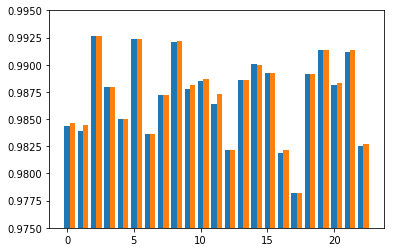

In [14]:
plt.bar(np.arange(num_experiments), train_scores, width=.4)
plt.bar(np.arange(num_experiments) + .4, train_scores2, width=.4)
plt.ylim(0.975, .995)

(0.975, 0.995)

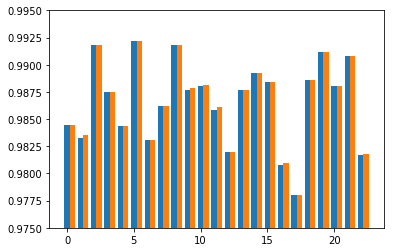

In [15]:
plt.bar(np.arange(num_experiments), test_scores, width=.4)
plt.bar(np.arange(num_experiments) + .4, test_scores2, width=.4)
plt.ylim(0.975, .995)

In [16]:
test_lps[0].shape

()

<Container object of 23 artists>

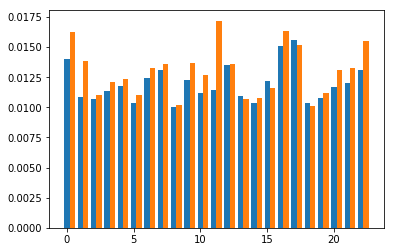

In [25]:
plt.bar(np.arange(num_experiments), np.array(train_lps) - np.array(train_baseline_lps), width=.4)
plt.bar(np.arange(num_experiments)+.4, np.array(train_lps2) - np.array(train_baseline_lps), width=.4)

<Container object of 23 artists>

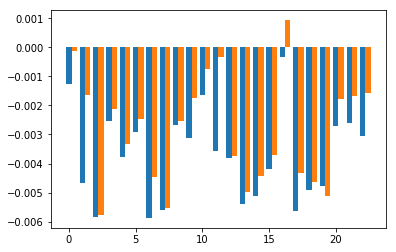

In [26]:
plt.bar(np.arange(num_experiments), np.array(test_lps) - np.array(test_baseline_lps), width=.4)
plt.bar(np.arange(num_experiments)+.4, np.array(test_lps2) - np.array(test_baseline_lps), width=.4)

In [32]:
y_train[0].mean(0)

array([0.00588334, 0.00201715, 0.04958817, 0.00537906, 0.01378383,
       0.01428812, 0.02302908, 0.06118675, 0.00470667, 0.02790385,
       0.02790385, 0.01159859, 0.00336191, 0.00470667, 0.02319718,
       0.00521096, 0.00588334, 0.02437384, 0.01680955, 0.00907716,
       0.00621953, 0.01327954, 0.00235334, 0.02908052, 0.01344764,
       0.06169104, 0.01445621, 0.01042192, 0.02286099, 0.04656245,
       0.00706001, 0.01697764, 0.01596907, 0.00437048, 0.00806858,
       0.00487477, 0.00403429, 0.00487477, 0.00521096, 0.03513195,
       0.00806858, 0.0036981 , 0.01143049, 0.00336191, 0.01193478,
       0.02269289, 0.01613717, 0.00638763, 0.00907716, 0.02336527,
       0.01630526, 0.02017146, 0.00437048, 0.00890906, 0.05496722,
       0.0038662 , 0.01294335, 0.01344764, 0.00571525, 0.00521096,
       0.0184905 , 0.01613717, 0.00991763, 0.00773239, 0.01193478,
       0.01159859, 0.04370482, 0.00554715, 0.00840477, 0.00706001,
       0.01512859, 0.01445621, 0.00890906, 0.00588334, 0.00521

In [18]:
i = 1
coupling = np.zeros((num_neurons[i], num_neurons[i]))
for n, lr in enumerate(all_lrs2[i]):
    wn = lr.coef_[0, 448:]
    coupling[:n,n] = wn[:n]
    coupling[n+1:,n] = wn[n:]


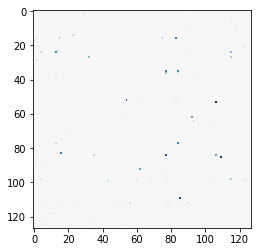

In [19]:
lim = abs(coupling).max()
plt.imshow(coupling, vmin=-lim, vmax=lim, cmap="RdBu")